# Model Checking and Evaluation

In [1]:
import numpy as np
import pandas as pd
from IPython.display import YouTubeVideo

import statsmodels.api as sm
import pymc as pm
import arviz as az
import bambi as bmb

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Turn off logging (console output) for PyMC
import logging
logging.getLogger("pymc").setLevel(logging.ERROR)

sns.set()

When fitting a model to data, it's important to ask the question: **is this model a good representation of the data**?

In this section, we'll answer this question from frequentist and Bayesian perspectives.

We'll consider model evaluation from two viewpoints:

1. Are our models a good fit for the data we used to fit them (in the case of prediction, our training data)?
2. Will our models (particularly prediction models) generalize well to new, previously unseen data?

When formulating and fitting a model, it's important to answer both of these questions. In practice, it's often easier to answer (and debug/iterate) the first question before moving on to the second.

In [2]:
YouTubeVideo('RlQNAjvm55A')

## Frequentist Model Checking

In the frequentist setting, we often use **goodness-of-fit** measures to evaluate our models. Let's return to the three different models we used to predict the number of turbines in Oklahoma:

In [3]:
# Load and preprocess the data
turbines = pd.read_csv('turbines.csv')
# The "year" column contains how many years since the year 2000
turbines['year'] = turbines['p_year'] - 2000
turbines = turbines.drop('p_year', axis=1)
# Turbines in Oklahoma from 2000 on
ok_filter = (turbines.t_state == 'OK')
ok_turbines = turbines[ok_filter].sort_values('year')

ok_turbines = ok_turbines[ok_turbines['year'] > 0]
ok_turbines["totals"] = np.cumsum(ok_turbines["t_built"])
# Log-transform the counts, too
ok_turbines["log_totals"] = np.log(ok_turbines["totals"])
ok_turbines

,t_state,t_built,t_cap,year,totals,log_totals
361,OK,1,100.0,1.0,1,0.000000
362,OK,113,176250.0,3.0,114,4.736198
363,OK,182,298200.0,5.0,296,5.690359
364,OK,40,60000.0,6.0,336,5.817111
365,OK,85,154500.0,7.0,421,6.042633
366,OK,91,141900.0,8.0,512,6.238325
367,OK,153,299100.0,9.0,665,6.499787
368,OK,195,352260.0,10.0,860,6.756932
369,OK,257,524900.0,11.0,1117,7.018402
370,OK,596,1127050.0,12.0,1713,7.446001


In [4]:
gaussian_model_intercept = sm.GLM(
    np.log(ok_turbines.totals), sm.add_constant(ok_turbines.year),
    family=sm.families.Gaussian()
)
gaussian_results = gaussian_model_intercept.fit()
print(gaussian_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          1.1810
Method:                          IRLS   Log-Likelihood:                -24.472
Date:                Sun, 12 Oct 2025   Deviance:                       17.716
Time:                        14:29:10   Pearson chi2:                     17.7
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9131
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2602      0.590      5.526      0.0

In [5]:
poisson_model_freq = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.Poisson()
)
poisson_results = poisson_model_freq.fit()
print(poisson_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -755.42
Date:                Sun, 12 Oct 2025   Deviance:                       1366.3
Time:                        14:29:10   Pearson chi2:                 1.20e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9697      0.023    219.386      0.0

In [6]:
negbin_model_freq = sm.GLM(
    ok_turbines.totals, sm.add_constant(ok_turbines.year),
    family=sm.families.NegativeBinomial()
)
negbin_results = negbin_model_freq.fit()
print(negbin_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 totals   No. Observations:                   17
Model:                            GLM   Df Residuals:                       15
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.14
Date:                Sun, 12 Oct 2025   Deviance:                       7.1483
Time:                        14:29:10   Pearson chi2:                     1.90
No. Iterations:                    11   Pseudo R-squ. (CS):             0.6999
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2059      0.544      7.725      0.0

/Users/ramesh/anaconda3/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### Model comparison with log-likelihood

The first way we'll compare these three models is by looking at the **log-likelihood**, $\log(p(y|\beta, x))$. We've already seen this quantity before when we looked at simpler frequentist models. It describes how likely the observed $y$-values are, given particular coefficients $\beta$ and predictors $x$. For 

For each of these three models, the specific form of the likelihood function is different:
1. The first log-likelihood describes the **density** of observing the log-transformed $y$-values, assuming linear regression
2. The second log-likelihood describes the **probability** of observing the original $y$-values as counts, assuming a Poisson model with an exponential inverse link function
3. The third log-likelihood describes the **probability** of observing the original $y$-values as counts, assuming a negative binomial model with an exponential inverse link function

So, we can interpret the log-likelihood as: "how likely are the data, according to a specific model?" 

Note that because of two key differences (continuous vs discrete likelihoods and log-transformed data), we cannot directly compare the log-likelihood from the first model with the second two. But, we can compare the second two log-likelihoods directly, since they each describe how likely **the same observations** $y_1, \ldots, y_n$ are, according to two different models. Just as we saw with maximum likelihood, it is reasonable to assume that the model with a higher log-likelihood is a better fit for the data.

Comparing the models, we see that the Poisson model has a log-likelihood of -755, while the negative binomial model has a log-likelihood around -134. We also know that because of how the models are fit, that these represent the best possible log-likelihood values for each model family. So, we can reasonably conclude that under a negative binomial GLM, the data are much more likely than they are under a Poisson GLM.

Intuitively, this aligns with what we saw in the Bayesian setting: because the variance of the Poisson likelihood is too low, values far away from the predicted average $\hat{y}$ are very unlikely, and so the model assigns low probability to the turbine counts that we actually observed.

Note that the log-likelihood for any model by itself does not tell us anything about that model's performance. Rather, it is useful as a **relative measure when comparing different models applied to the same dataset.** So, in general, the log-likelihood tells us how well a model does on a particular dataset, and can be used to compare how well different models fit the same dataset.

### Model evaluation with chi-squared statistic

We can also use the chi-squared ($\chi^2$) statistic to evaluate models: here, larger values are better. While the full details are beyond the scope of this class, in general, we should expect the Chi-squared statistic to roughly be equal to the number of data points minus the number of parameters. In the examples above, we have 17 data points (observations), and two parameters (slope and intercept), so we should expect a value close to 15.

We can see that the linear model (with log-transformed $y$-values) has a Chi-squared value of 17.7, fairly close to 15, indicating that the model fits the data well. The Poisson model, on the other hand, has a much higher value of 1200, indicating a very poor fit.

#### Intuition behind the chi-squared statistic

*Coming soon: see video*

In [7]:
YouTubeVideo('wTNETHYrUl8')

## Bayesian Model Checking

### Posterior Predictive Distributions

Consider a model with observed data points $x_{1:n} = x_1, \ldots, x_n$ and an unknown parameter, with a likelihood $p(x_{1:n}|\theta)$ and a prior $p(\theta)$. As usual, we'll assume that the data points are conditionally i.i.d. given $\theta$. So far, we've focused on obtaining the posterior distribution $p(\theta|x_{1:n})$.

We can also consider the distribution for a new data point, given all the previous data points (after marginalizing out the unknown parameter $\theta$). This is called the **posterior predictive distribution (PPD)**, and will be our primary tool for model checking:

$$
p(x_{n+1} | x_1, \ldots, x_n)
$$

How do we go about computing the PPD? Looking at the previous paragraph, we know more about the distribution of $x_{n+1}$ given $\theta$, so we can use total probability:

$$
p(x_{n+1}|x_{1:n}) = \int p(x_{n+1}|x_{1:n}, \theta)p(\theta|x_{1:n})\, d\theta
$$

We can simplify the first conditional distribution because $x_{n+1}$ and $x_{1:n}$ are conditionally independent given $\theta$: in other words, $p(x_{n+1}|x_{1:n}, \theta) = p(x_{n+1}|\theta)$. The second conditional distribution is the posterior distribution for $\theta$. So:

$$
\begin{align*}
p(x_{n+1}|x_{1:n}) 
    &= \int p(x_{n+1}|x_{1:n}, \theta)p(\theta|x_{1:n})\, d\theta \\
    &= \int p(x_{n+1}|\theta)p(\theta|x_{1:n})\, d\theta \\
    &= \mathbb{E}_{\theta|x_{1:n}}\left[p(x_{n+1}|\theta)\right]
\end{align*}
$$

In practice, computing this integral exactly is just as hard as computing the denominator in Bayes' rule, because we have to integrate out over all possible $\theta$. In the case of high-dimensional $\theta$, as before, the integral can be impossible! In practice, we usually approximate the posterior with samples, and then use that to approximate the PPD.

Specifically, to compute the PPD for a new data point, we compute the expectation above using the empirical distribution for $\theta|x_{1:n}$ as defined by the samples. 

In other words, given samples $\theta^{(1)}, \ldots, \theta^{(t)}$ that approximate $p(\theta|x_{1:n})$, we can:
* **compute the PPD for a specific value** $x_{n+1}$ by averaging $(1/t)\sum_{i=1}^t p(x_{n+1}|\theta^{(t)})$
* **draw a sample from the PPD** by:
  * first, drawing a sample uniformly at random from $\theta^{(1)}, \ldots, \theta^{(t)}$, calling it $\theta^*$;
  * and then drawing from the likelihood conditioned on that sample, $p(x_{n+1}|\theta^*)$

### Using the PPD to check regression

In a Bayesian GLM, our observed data points are the $y$-values $y_1, \ldots, y_n$. So, the PPD is $p(y_{n+1} | x_{n+1}, y_1, \ldots, y_n)$. Note that we condition on the corresponding $x$-value because of the nature of a prediction/regression problem. $x$ is fixed and known, and $y_{n+1}$ will depend on $x_{n+1}$. Another way of seeing this is by trying to answer the question of "how would you predict $y_{n+1}$ without knowing $x_{n+1}$, and would that prediction even be useful?"

PyMC handles all the details of setting up the posterior predictive check for us, so we can define the following function to help us visualizes the samples that it draws. The most important line is `model.predict(trace, kind='response')`, which tells PyMC to generate predictions for each $x$-value by sampling from the posterior predictive distribution.

*Exercise: what are the other possible values of `kind=` that you can pass to the `model.predict()` function, and what do they do?*

In [8]:
def show_posterior_predictive(
    model, trace, turbines_df, 
    is_log_y=False, num_lines=40, ax=None
):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    N = turbines_df.shape[0]
    # Adds posterior predictive samples to the trace
    model.predict(trace, kind='response')

    y_name = model.response_component.response.name
    # a num_samples x 17 array with num_samples different
    # predictions from the PPC
    pred_arr = trace.posterior_predictive[y_name].values.reshape(-1, N)
    if is_log_y:
        pred_arr = np.exp(pred_arr)

    for i in range(num_lines):
        ax.plot(
            turbines_df['year'], pred_arr[i], alpha=0.1, color='green'
        )
    
    ax.scatter(turbines_df['year'], turbines_df['totals'])
    # This value is hard-coded to help us see the PPCs for all 3
    # models on the same scale
    ax.set_ylim([0, 30000])

Now, let's use this function to visualize a PPC for the three models we looked at in the previous section.

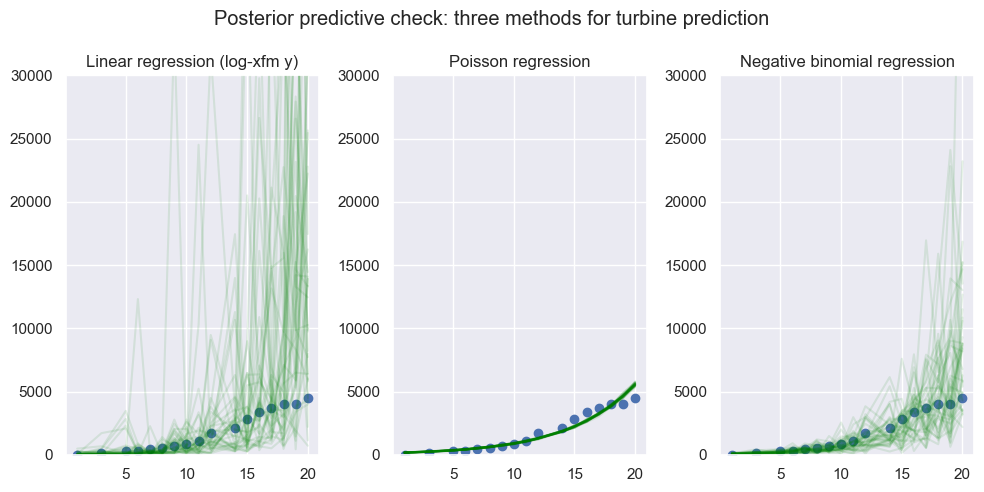

In [9]:
# First, we need to set up and draw posterior samples for each model
gaussian_model = bmb.Model(formula='log_totals ~ year', data=ok_turbines, family='gaussian')
gaussian_trace = gaussian_model.fit(random_seed=0, progressbar=False)

poisson_model = bmb.Model(formula='totals ~ year', data=ok_turbines, family='poisson')
poisson_trace = poisson_model.fit(random_seed=0, progressbar=False)

negbin_model = bmb.Model(formula='totals ~ year', data=ok_turbines, family='negativebinomial')
negbin_trace = negbin_model.fit(random_seed=0, progressbar=False)

# Now, visualize the PPC using the function we just defined
f, axes = plt.subplots(1, 3, figsize=(10, 5))
show_posterior_predictive(gaussian_model, gaussian_trace, ok_turbines, is_log_y=True, ax=axes[0])
axes[0].set_title('Linear regression (log-xfm y)')

show_posterior_predictive(poisson_model, poisson_trace, ok_turbines, is_log_y=False, ax=axes[1])
axes[1].set_title('Poisson regression')

show_posterior_predictive(negbin_model, negbin_trace, ok_turbines, is_log_y=False, ax=axes[2])
axes[2].set_title('Negative binomial regression')

f.suptitle('Posterior predictive check: three methods for turbine prediction')
plt.tight_layout()

Each green line represents one sample from the PPD. We can think of these as possible sequences of data that are dreamt up by the models, based on their representation. 

Looking at the results, we can immediately make a few observations:
* We can see again that Poisson regression is overconfident: every single one of the PPD samples is on (or extremely close to) the regression line, with little observed variability around it.
* The other two models both have trajectories that go up and down, while the true pattern is monotonically nondecreasing. This is a weakness of our models: specifically, we assume that the $y$-values are conditionally i.i.d.
* The samples from the linear regression have an enormous amount of variability: we can see that many of them make predictions well over 15,000 turbines starting in 2015, which is far more than the actual observed values. This tells us that the model allows for too much variability.
* The negative binomial model has a much more reasonable range of values, at least before 2018. One could imagine that under different political and economic circumstances, Oklahoma might have built more or fewer turbines in accordance with these predictions. While the model still has a little too much variability, it's still much more reasonable than the 

Note that all of the above required some subjective evaluation and a bit of domain knowledge! In many cases, where we have not just one observed $y$-value per unique value of $x$ but instead a cloud of points, we can produce quantitative evaluations from the PPC, such as comparing the variance of the observed $y$-values to the variance of the PPC samples, but the details of such procedures are beyond the scope of this class.

*Exercise: Recall that the outlier in 2000 ($t=0$) affected our predictions, likely causing the slope to be too high across all three models. Try fitting the three models above after removing that outlier from the dataset. Do the results change? How and why?*